In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

# Now, let's use APE to find prompts that generate antonyms for each word.
from automatic_prompt_engineer import ape

In [4]:
%run 01_LLMs_konfigurieren.ipynb

In [5]:
%run 02_Daten_laden.ipynb

In [7]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:5]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


# APE ausprobieren

In [17]:
# First, let's define a simple dataset 

text = sst2_subset['sentence'].tolist()

label = ['negative','negative','positive','negative','negative'] # sst2_subset['label'].tolist()
data = (text, label)


In [18]:
# Now, we need to define the format of the prompt that we are using.

eval_template = \
"""Instruction: [PROMPT]
Input: [INPUT]
Output: [OUTPUT]"""

In [20]:
# Now, let's use APE to find prompts that generate antonyms for each word.
from automatic_prompt_engineer import ape

result, demo_fn = ape.simple_ape(
    dataset=(text, label),
    eval_template=eval_template,
)

Generating prompts...
[GPT_forward] Generating 50 completions, split into 1 batches of size 2000


  0%|          | 0/1 [00:00<?, ?it/s]



You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Retrying...


  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [15]:
prompt_gen_template = """
I asked an LLM to classify the sentiment of the following input-output pairs based on an instruction:
[full_DEMO]
The instruction was: [APE]
"""

In [16]:
from automatic_prompt_engineer import ape

result, demo_fn = ape.simple_ape(
    dataset=data,                  # dein Sentiment-Datensatz
    eval_template=eval_template,   # Evaluation-Template
    prompt_gen_template=prompt_gen_template, # Prompt-Generierungs-Template
    num_prompts=20,                # Anzahl der zu erstellenden Prompt-Kandidaten
    eval_rounds=5                 # Anzahl der Evaluationsrunden
)

Generating prompts...


TypeError: replace() argument 2 must be str, not int

In [58]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1000]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
995,995,you wish you were at home watching that movie ...,0
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0


In [59]:
sb10k_subset = sb10k_combined[:1000]
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


# Chain of thought

## OpenAI / GPT

In [60]:
openai_client

### SST2

In [61]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [67]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[528:1001]
sst2_subset

,index,sentence,label
528,528,directed with purpose and finesse by england '...,1
529,529,it 'll probably be in video stores by christmas,0
530,530,"funny , triumphant ,",1
531,531,underachiever,0
532,532,a film of ideas and wry comic mayhem,1
...,...,...,...
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0
999,999,a heartening tale of small victories,1


In [ ]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df1 = pd.DataFrame(columns=['index', 'sentence','all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

## Prompts

system_prompt = """You classify sentiments of a text. Final_answer should be ONLY negative or positive!
Analyze the text step-by-step to determine whether it expresses positive or negative sentiment.
Explain each step in detail before providing your final answer."""

user_prompt = ("""       
Classify the sentiment of the following text into one of these two sentiments ['negative', 'positive'].
""")

# Anzahl der Antworten, die vom Modell angefordert werden
n = 3 # um statistics error zu vermeiden

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']

    answers = []
    all_steps = []
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( 
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { 
                "role": "system", 
                "content": system_prompt
                    
                },
                {
                "role": "user",
                 "content": (user_prompt + f"Text: {text}:")
                }
            ],
            temperature = 0.5,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed 
            result_step = response_content.steps
            final_answer = response_content.final_answer
            
            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )
        
        # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df1.loc[row_counter] = [index, text, all_steps, answers, consistent_answer]
            row_counter += 1
            

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




528 n=  0 Label:  positive
528 n=  1 Label:  positive
528 n=  2 Label:  positive
529 n=  0 Label:  positive
529 n=  1 Label:  negative
529 n=  2 Label:  neutral
530 n=  0 Label:  positive
530 n=  1 Label:  positive
530 n=  2 Label:  positive
531 n=  0 Label:  negative
531 n=  1 Label:  negative
531 n=  2 Label:  negative
532 n=  0 Label:  positive
532 n=  1 Label:  positive
532 n=  2 Label:  positive
533 n=  0 Label:  positive
533 n=  1 Label:  positive
533 n=  2 Label:  positive
534 n=  0 Label:  negative
534 n=  1 Label:  negative
534 n=  2 Label:  negative
535 n=  0 Label:  negative
535 n=  1 Label:  negative
535 n=  2 Label:  negative
536 n=  0 Label:  negative
536 n=  1 Label:  negative
536 n=  2 Label:  negative
537 n=  0 Label:  negative
537 n=  1 Label:  negative
537 n=  2 Label:  negative
538 n=  0 Label:  negative
538 n=  1 Label:  negative
538 n=  2 Label:  negative
539 n=  0 Label:  positive
539 n=  1 Label:  positive
539 n=  2 Label:  positive
540 n=  0 Label:  negative
54

In [65]:
results_gpt_df

,index,sentence,all_steps,all_labels,generated_label
0,0,hide new secretions from the parental units,"[[explanation='The phrase ""hide new secretions...","[negative, negative, negative]",negative
1,1,"contains no wit , only labored gags","[[explanation=""The phrase 'contains no wit' su...","[negative, negative, negative]",negative
2,2,that loves its characters and communicates som...,"[[explanation=""The phrase 'that loves its char...","[positive, positive, positive]",positive
3,3,remains utterly satisfied to remain the same t...,"[[explanation=""The phrase 'remains utterly sat...","[positive, positive, positive]",positive
4,4,on the worst revenge-of-the-nerds clichés the ...,"[[explanation=""The phrase 'on the worst reveng...","[negative, negative, negative]",negative
...,...,...,...,...,...
523,523,a diverse and astonishingly articulate cast of...,"[[explanation=""The text describes a 'diverse a...","[positive, positive, positive]",positive
524,524,anyone who suffers through this film,"[[explanation=""The phrase 'anyone who suffers ...","[negative, negative, negative]",negative
525,525,one carried by a strong sense of humanism,"[[explanation=""The phrase 'one carried by a st...","[positive, positive, positive]",positive
526,526,"for all its brilliant touches , dragon loses i...","[[explanation='The phrase ""for all its brillia...","[negative, negative, negative]",negative


In [ ]:
results_gpt_df

In [25]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_52930/829187267.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})


In [32]:
results_gpt_df['generated_label'].unique()

array([0, 1])

In [27]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_SelfConsistency_GPT.csv')


### Evaluation

In [28]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.85
Precision: 0.99
Recall: 0.73
F1-Score: 0.84
Confusion Matrix:
[[452   6]
 [145 398]]


### SB10k

In [51]:
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


In [43]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

system_prompt = "Du klassifizierst die Sentiments eines Textes. Gib für final_answers NUR ['negativ', 'neutral', 'positiv'] zurück." 

user_prompt = f"""Klassifiziere das Sentiment des folgenden Text in ['negativ', 'neutral', 'positiv'].
Analysiere den Text Schritt für Schritt, um zu bestimmen, ob er eine positive, negative oder neutrale Stimmung ausdrückt.
Erkläre jeden Schritt im Detail, bevor du deine endgültige Antwort gibst.
Text: {text}."""

# Anzahl der Antworten, die vom Modell angefordert werden
n = 3

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']

    answers = []
    all_steps = []
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( 
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { 
                "role": "system", 
                "content": system_prompt
                    
                },
                {
                "role": "user",
                 "content": (user_prompt + f"Text: {text}:")
                }
            ],
            temperature = 0.2,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed 
            result_step = response_content.steps
            final_answer = response_content.final_answer
            
            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )
        
        # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df.loc[row_counter] = [index, text, all_steps, answers, consistent_answer]
            row_counter += 1
            

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




0 n=  0 Label:  positiv
0 n=  1 Label:  positiv
0 n=  2 Label:  positiv
1 n=  0 Label:  positiv
1 n=  1 Label:  neutral
1 n=  2 Label:  positiv
2 n=  0 Label:  neutral
2 n=  1 Label:  neutral
2 n=  2 Label:  neutral
3 n=  0 Label:  positiv
3 n=  1 Label:  positiv
3 n=  2 Label:  positiv
4 n=  0 Label:  positiv
4 n=  1 Label:  neutral
4 n=  2 Label:  positiv
5 n=  0 Label:  positiv
5 n=  1 Label:  positiv
5 n=  2 Label:  positiv
6 n=  0 Label:  positiv
6 n=  1 Label:  positiv
6 n=  2 Label:  positiv
7 n=  0 Label:  negativ
7 n=  1 Label:  neutral
7 n=  2 Label:  neutral
8 n=  0 Label:  positiv
8 n=  1 Label:  positiv
8 n=  2 Label:  positiv
9 n=  0 Label:  positiv
9 n=  1 Label:  positiv
9 n=  2 Label:  positiv
10 n=  0 Label:  positiv
10 n=  1 Label:  positiv
10 n=  2 Label:  positiv
11 n=  0 Label:  positiv
11 n=  1 Label:  positiv
11 n=  2 Label:  positiv
12 n=  0 Label:  positiv
12 n=  1 Label:  positiv
12 n=  2 Label:  positiv
13 n=  0 Label:  positiv
13 n=  1 Label:  positiv
13 n=

In [45]:
results_gpt_df

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",positiv
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[[explanation=""Der Text beginnt mit den Wörter...","[positiv, neutral, positiv]",positiv
2,2,Aber wenigstens kommt #Supernatural heute mal ...,[[explanation='Der Text beginnt mit den Worten...,"[neutral, neutral, neutral]",neutral
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",positiv
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, neutral, positiv]",positiv
...,...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, neutral, neutral]",neutral
996,996,Cros Kindermusik braucht keiner .,"[[explanation=""Der erste Teil des Textes besch...","[negativ, negativ, negativ]",negativ
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",positiv
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[[explanation='Der erste Teil des Textes besch...,"[positiv, positiv, positiv]",positiv


In [46]:
# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_sb10k_df_ver = results_gpt_df # [results_gpt_sb10k_df['generated_label'].isin(['0', '1','2',0,1,2])]

# Mapping: 'negative', 'negativ' zu 0, 'positive', 'positiv' zu 1, 'neutral' zu 2
results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_sb10k_df_final = results_gpt_sb10k_df_ver[results_gpt_sb10k_df_ver['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gpt_sb10k_df_final['generated_label'] = results_gpt_sb10k_df_final['generated_label'].astype(int)


/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_52930/2419785378.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({


In [52]:
results_gpt_sb10k_df_final

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[[explanation=""Der Text beginnt mit den Wörter...","[positiv, neutral, positiv]",1
2,2,Aber wenigstens kommt #Supernatural heute mal ...,[[explanation='Der Text beginnt mit den Worten...,"[neutral, neutral, neutral]",2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",1
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, neutral, positiv]",1
...,...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, neutral, neutral]",2
996,996,Cros Kindermusik braucht keiner .,"[[explanation=""Der erste Teil des Textes besch...","[negativ, negativ, negativ]",0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,"[[explanation=""Der Text beginnt mit den Worten...","[positiv, positiv, positiv]",1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[[explanation='Der erste Teil des Textes besch...,"[positiv, positiv, positiv]",1


In [48]:
# CSV abspeichern 
results_gpt_sb10k_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_SelfConsistency_GPT.csv', encoding='utf-8-sig')


#### Evaluation

In [49]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gpt_sb10k_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.45
Precision (macro): 0.50
Recall (macro): 0.56
F1-Score (macro): 0.46
Confusion Matrix:
[[ 87  16  58]
 [  9 199  26]
 [ 87 351 167]]


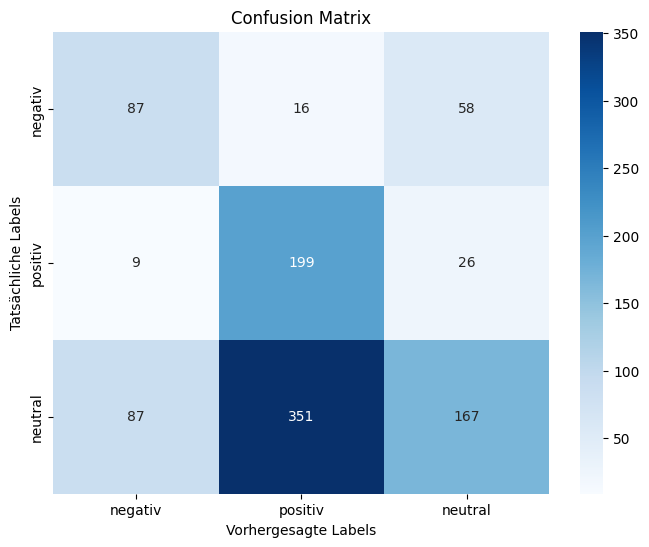

In [50]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [18]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash-001',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### SST2

In [20]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
    You classify sentiments of a text. Think step-by-step and use this JSON Schema: Result = {'steps':str, 'final_answer': str}
    Example:
        Input: Classify the following text ONLY in one of these two sentiments ['negative', 'positive']. Text: "The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work."
        Answer: {'steps': "The sentence “The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work” can be classified as negative because several factors point to disappointment and deficiencies. 
                First, the film’s low to mid-range budget is mentioned, which might seem neutral or slightly negative at first. 
                However, the phrase “betrayed by” indicates an unexpected weakness, suggesting that a particular aspect highlights the film’s lower quality. 
                The term “surprisingly shoddy makeup work” is described as especially disappointing. The word “shoddy” means substandard or poorly done, and the fact that this is “surprisingly” bad suggests that better quality was expected. 
                This combination of unmet expectations and the emphasis on a negative aspect leads to an overall negative judgment.", 
                'final_answer': Negative
                 """,
    generation_config={"response_mime_type": "application/json"})


# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""Classify the following text ONLY in one of these two sentiments 
                                                ['negative', 'positive']. Text: {text}.""")
        llm_output = response.text
        #print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)
        #print(resp_dict)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   0 

1   0 

2   1 

3   0 

4   0 

5   0 

6   1

7   0 

8   0 

9   1 

10   0 

11   0 

12   0 

13   0 

14   0 

15   1 

16   0 

17   1 

18   0 

19   1

20   1

21   1 

22   1

23   1

24   0 

25   1 

26   0 

27   0 

28   1

29   0 

30   0 

31   1 

32   0 

33   0 

34   0 

35   1 

36   1 

37   1 

38   0 

39   0 

40   0 

41   0 

42   0 

43   1

44   0 

45   1

46   1 

47   0 

48   1 

49   0 

50   0 

51   1 

52   0 

53   1 

54   0 

55   0 

56   0 

57   1 

58   1 

59   0 

60   1

61   0 

62   0 

63   0 

64   0 

65   1 

66   0 

67   0 

68   0 

69   1

70   0 

71   0 

72   1 

73   0 

74   0 

75   1

76   0 

77   0 

78   0 

79   1

80   1

81   0 

82   1 

83   1 

84   1 

85   0 

86   1 

87   1

88   1 

89   1 

90   0 

91   1 

92   0 

93   1

94   1

95   1 

96   0 

97   1 

98   1

99   1

100   0 

101   1 

102   0 

103   0 

104   0 

105   1 

106   0 

107   0 

108   1 

109   0 

110   0 

111   0 

112   1


In [ ]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [21]:

# CSV abspeichern 
results_gemini_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_CoT_GEMINI.csv', encoding='utf-8-sig')


#### Evaluation

In [22]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.91
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
Confusion Matrix:
[[452   5]
 [ 87 455]]


### SB10k

In [23]:
# system-prompt gemini

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  safety_settings='BLOCK_NONE',

  system_instruction=
    """
            Du klassifizierst die Sentiments eines Textes. Denke Schritt für Schritt und verwende dieses JSON Schema: Result = {'steps':str, 'final_answer': str}
            Beispiel:
            Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                    Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
            Antwort: 
            {'steps': "Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
            da er keine emotionalen oder wertenden Elemente enthält. 
            Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
            Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
            Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
            Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.",
            'final_answer: 2'}
    """,
  generation_config={"response_mime_type": "application/json"}
    )

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""Du klassifizierst die Sentiments eines Textes. 
                                                Denke Schritt-für-Schritt.
                                                Text: {text}""")
        llm_output = response.text
        #print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)
        #print(resp_dict)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1
    
    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   2

1   2

2   0 

3   2

4   0 

5   2

6   1 

7   0 

8   2

9   1

10   1

11   2

12   2

13   2

14   1

15   0 

16   0

17   2

18   2

19   1

20   0 

21   2

22   1

23   1

24   2

25   2

26   2

27   2

28   0

29   2

30   2

31   0 

32   0

33   1

34   2

35   2

36   0

37   2

38   2

39   2

40   0 

41   2 

42   0 

43   2

44   1

45   1

46   2

47   1

48   0 

49   0 

50   2

51   0

52   1

53   0 

54   0

55   0 

56   1

57   1

58   0 

59   2

60   2 

61   2

62   2 

63   2 

64   2

65   2 

66   1

67   1

68   1

69   2

70   0 

71   2

72   0

73   1

74   0 

75   1

76   1

77   2

78   2

79   2

80   1

81   2

82   1

83   0

84   2

85   1

86   0 

87   2

88   0 

89   1

90   2

91   1

92   2 

93   0 

94   1

95   1

96   2

97   0

98   0 

99   2

100   1

101   0 

102   1

103   2

104   2

105   0 

106   0 

107   2

108   2

109   1

110   1

111   2

112   2

113   0 

114   0 

115   1

116   2

117   1

Fehler bei der Ve

In [ ]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [24]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_CoT_GEMINI.csv', encoding='utf-8-sig')



#### Evaluation

In [25]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.60
Precision (macro): 0.60
Recall (macro): 0.68
F1-Score (macro): 0.59
Confusion Matrix:
[[137   4  13]
 [ 25 151  54]
 [190 105 300]]


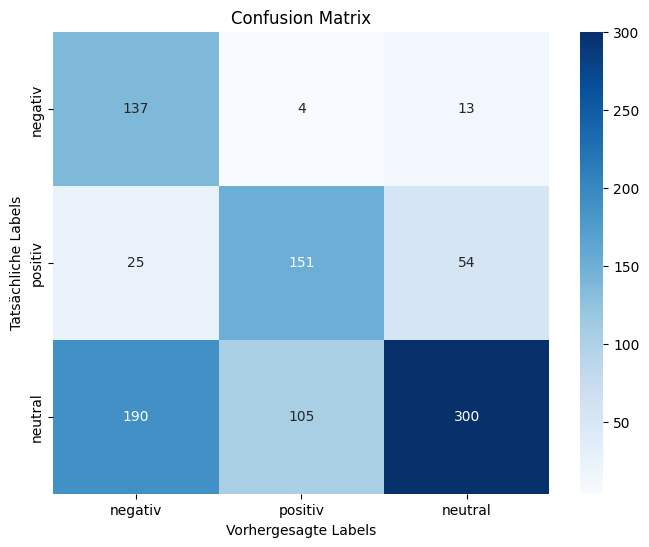

In [26]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()